<a href="https://colab.research.google.com/github/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-04-MACHINE-LEARNING-1/blob/master/20-[TALLER]_Pipeline_Solucion_Problema_de_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras alamancenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-04-MACHINE-LEARNING-1/master/init.py
import init; init.init(force_download=False); 

# Taller

El objetivo este taller es recoger lo visto en el módulo y aplicarlo a la solución de un problema real. El problema que vamos a resolver es la identificación y clasificación de comentarios tóxicos en línea. Los detalles del conjunto de datos pueden ser consulatos [aquí](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview).

In [ ]:
!pip install scikit-learn==0.22

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df = pd.read_csv('local/data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

Veamos algunas muestras de la base datos:

In [3]:
df["comment_text"] = df["comment_text"].str.lower()
df[:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\ncongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
df.shape

(159571, 8)

Desde el punto de vista de ML, el problema predictivo corresponde a un problema de múltiples etiquetas:

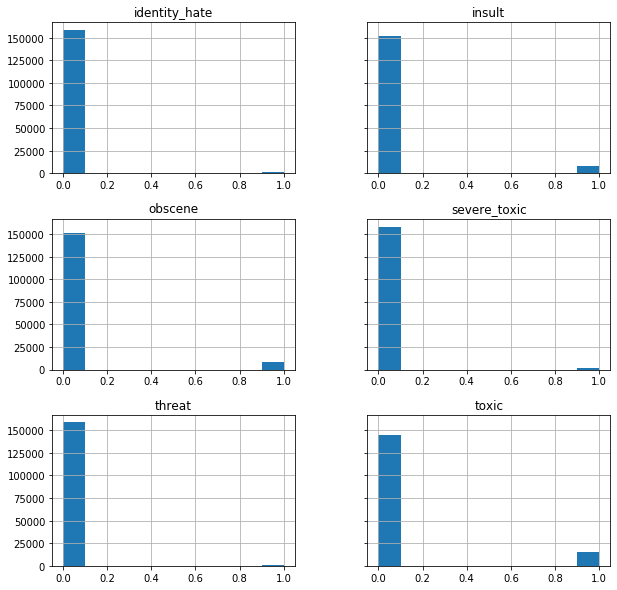

In [5]:
ax= df.hist(column=['toxic','severe_toxic','obscene','threat','insult','identity_hate'],sharey=True,figsize=(10, 10))

La base de datos completa es muy grande, por lo tanto tomaremos sólo una parte para este ejercicio. Abordaremos el problema de predecir tres clases de contenido: 'toxic', 'obscene','insult'. Adicionalmente, teniendo en cuenta que muchas muestras no pertenecen a ninguna de las clases, eliminaremos principalmente muestras de ese conjunto.

In [6]:
np.random.seed(seed=0)
df2 = df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0)]
df = df.drop(['severe_toxic', 'threat', 'identity_hate'], axis=1)
df2 = df2.drop(['severe_toxic', 'threat', 'identity_hate'], axis=1)
df1 = df[(df['toxic']!=0) | (df['obscene']!=0) | (df['insult']!=0)]
remove_n = 130000
drop_indices = np.random.choice(df2.index, remove_n, replace=False)
df2 = df2.drop(drop_indices)
remove_n = 5000
drop_indices = np.random.choice(df1.index, remove_n, replace=False)
df1 = df1.drop(drop_indices)

In [7]:
df_final = pd.concat([df1, df2])

In [8]:
df_final.shape

(24495, 5)

Algunas muestras pueden no tener texto asociado, así que las imputaremos con la palabra: unknown 

In [9]:
COMMENT = 'comment_text'
df_final[COMMENT].fillna("unknown", inplace=True)

In [10]:
df_final['comment_text'][df_final.index[6]]

'=tony sidaway is obviously a fistfuckee. he loves an arm up his ass.'

In [11]:
lens = df_final.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(358.48169014084505, 605.5713565714727, 5000)

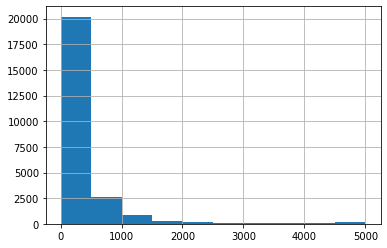

In [12]:
lens.hist();

**Nota**: De las anteriores gráficas se puede observar que todas las clases a predecir están desbalanceadas, pero la estrategia de validación estratificada estándar sólo puede fijarse en una. Un método al ternativo, llamado estratificación iterativa puede consultarse en el siguiente [artículo](https://link.springer.com/content/pdf/10.1007%2F978-3-642-23808-6_10.pdf) Su implementación está disponible en la librería [scikit-multilearn](http://scikit.ml/stratification.html)

In [13]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_final['comment_text'],df_final[['toxic','obscene','insult']], test_size=0.2, random_state=42, stratify=df_final['insult'])

# Ejemplo: Random Forest en esquema One vs Rest

In [15]:
y_unique = ['toxic','obscene','insult']
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', max_features = 2000, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words='english')),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample')))])

In [16]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
tuned_parameters = [{"tfidf__max_features":[1000,2000],
                     "clf__estimator__n_estimators": [100,150,200,250,300,350,400],
                     "clf__estimator__max_depth": [10,12,14,16],
                     "clf__estimator__max_features":['auto','sqrt','log2']},
                   {"clf__estimator__n_estimators": [100,150,200,250,300,350,400],
                     "clf__estimator__max_depth": [None],
                     "clf__estimator__max_features":['auto','sqrt','log2'],
                     "clf__estimator__min_samples_split":[10,20,30,40]}]

In [17]:
kf = KFold(n_splits=3)
model_tunning = GridSearchCV(classifier, param_grid=tuned_parameters,
                             scoring=make_scorer(accuracy_score), n_jobs=-1, cv=kf, verbose=2)

model_tunning.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  2.0min
/home/julian/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed: 18.2min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=2000,
                                                        min_df=3,
                                                        ngram_range=(1

In [18]:
model_tunning.best_estimator_.steps[2]

('clf', OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      class_weight='balanced_subsample',
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=20,
                                                      min_weight_fraction_leaf=0.0,
       

In [19]:
model_tunning.best_score_

0.6964686670749133

In [20]:
X_test

87939     "for instance, read what the dynasts were sayi...
45721     "\n\nthe publication ""the chamcha age"" - an ...
42610     don't be stupid. you know, i'm twice as irrita...
127722    whoever created this page is either very jelou...
135802    that's libel right there. murder is defined as...
                                ...                        
58193     "\nthank you for applying to access the accoun...
159460    , 24 january 2010 (utc)\nwikipedia is hosted i...
4251      that's a good idea (assuming someone from the ...
16255     "\nactually, we've been removing many ""terror...
50872     "\n\n please do not vandalize pages, as you di...
Name: comment_text, Length: 4899, dtype: object

In [21]:
y_pred = model_tunning.predict(X_test)
cm = multilabel_confusion_matrix(y_test, y_pred)

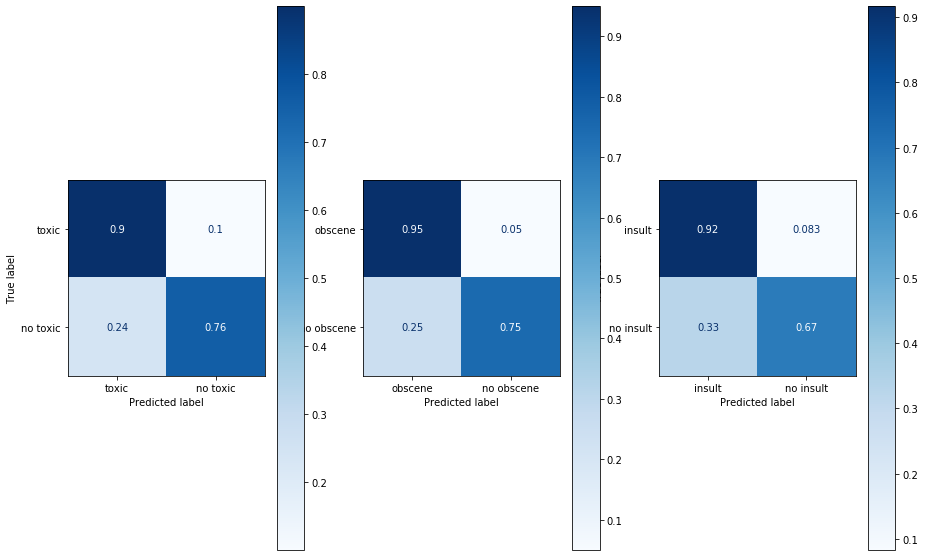

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

for i, (k, ax) in enumerate(zip(y_unique, axes.flatten())):
    label = []
    label.append(k)
    label.append('no '+ k) 
    disp = ConfusionMatrixDisplay(confusion_matrix=(cm[i].T/np.sum(cm[i],axis=1)).T, display_labels=label)
    disp.plot(include_values=True,cmap=plt.cm.Blues, ax=ax, xticks_rotation='horizontal',
          values_format=None)
plt.show()

In [23]:
y_pred_train = model_tunning.predict(X_train)
print(f"Global train error = {hamming_loss(y_train, y_pred_train)}")
print(f"Global test error = {hamming_loss(y_test, y_pred)}")

Global train error = 0.013676260461318637
Global test error = 0.13213581002925767


Podemos averiguar cuántas palabras fueron incluidas en el diccionario:

In [24]:
model_tunning.best_estimator_.steps[2][1].estimators_[0].n_features_

2000

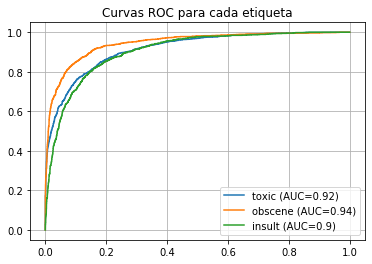

In [25]:
p_pred = model_tunning.predict_proba(X_test)
for i,j in enumerate(y_unique):
    score_pred = p_pred[:,i].copy()
    fpr, tpr, _ = roc_curve(y_test.values[:,i], score_pred)
    plt.plot(fpr, tpr, label=j+' '+ '(AUC=' + str(round(auc(fpr, tpr),2)) +')')
plt.legend()
plt.title('Curvas ROC para cada etiqueta')
plt.grid()
plt.show()

# Variante: Random Forest Multi-task

In [26]:
class_weight_list = []
for i in range(len(y_unique)):
    labels = np.unique(y_train.values[:,i])
    temp = compute_class_weight('balanced',labels,y_train.values[:,i])
    class_weight_list.append({labels[0]:temp[0], labels[1]:temp[1]})

classifier = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', max_features = 2000, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words='english')),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', RandomForestClassifier(class_weight=class_weight_list))])

In [27]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
tuned_parameters = [{"clf__n_estimators": [100,150,200,250,300,350,400],
                     "clf__max_depth": [10,12,14,16],
                     "clf__max_features":['auto','sqrt','log2']},
                   {"clf__n_estimators": [100,150,200,250,300,350,400],
                     "clf__max_depth": [None],
                     "clf__max_features":['auto','sqrt','log2'],
                     "clf__min_samples_split":[10,20,30,40]}]

In [28]:
kf = KFold(n_splits=3)
model_tunning = GridSearchCV(classifier, param_grid=tuned_parameters,
                             scoring=make_scorer(accuracy_score), n_jobs=-1, cv=kf, verbose=2)

model_tunning.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
/home/julian/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:  9.0min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.9,
                                                        max_features=2000,
                                                        min_df=3,
                                                        ngram_range=(1

In [30]:
model_tunning.best_estimator_.steps[2][1]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight=[{0: 0.8792175161521896,
                                      1: 1.1592522479886418},
                                     {0: 0.6563504823151125,
                                      1: 2.0989717223650386},
                                     {0: 0.6429977687360546,
                                      1: 2.2482790270766406}],
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
model_tunning.best_score_

0.6730965503163912

In [32]:
y_pred = model_tunning.predict(X_test)
cm = multilabel_confusion_matrix(y_test, y_pred)

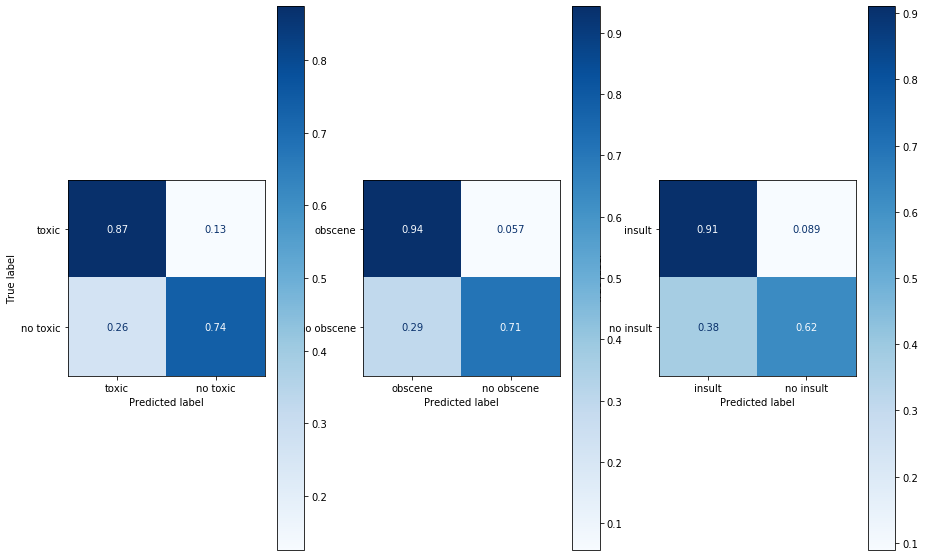

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

for i, (k, ax) in enumerate(zip(y_unique, axes.flatten())):
    label = []
    label.append(k)
    label.append('no '+ k) 
    disp = ConfusionMatrixDisplay(confusion_matrix=(cm[i].T/np.sum(cm[i],axis=1)).T, display_labels=label)
    disp.plot(include_values=True,cmap=plt.cm.Blues, ax=ax, xticks_rotation='horizontal',
          values_format=None)
plt.show()

In [34]:
y_pred_train = model_tunning.predict(X_train)
print(f"Global train error = {hamming_loss(y_train, y_pred_train)}")
print(f"Global test error = {hamming_loss(y_test, y_pred)}")

Global train error = 0.013438116622439954
Global test error = 0.1493502075253453


## Ejercicio 1

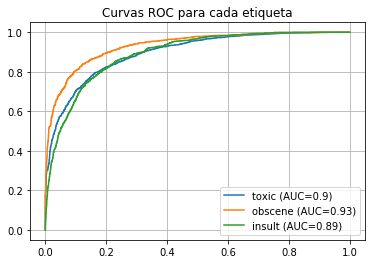

In [40]:
#Ejercicio de código
p_pred = model_tunning.predict_proba(X_test)
for i,j in enumerate(y_unique):
    #OJO: Son tres salidas...
    score_pred = ...
    fpr, tpr, _ = roc_curve(y_test.values[:,i], score_pred)
    plt.plot(fpr, tpr, label=j+' '+ '(AUC=' + str(round(auc(fpr, tpr),2)) +')')
plt.legend()
plt.title('Curvas ROC para cada etiqueta')
plt.grid()
plt.show()

## Ejericicio 2.

Realizar un proceso similar al anterior pero para una Red Neuronal Aritificial. En este caso evalúe máximo 2 capas ocultas con las siguientes configuraciones: (64,32) (128,64). Incluya parámetro de regularización dentro de la búsqueda de hiperparámetros y modifique también el número máximo de época de acuerdo con el siguiente conjunto: [30, 60, 100]. También puede variar el tamaño del batch: batch_size y la política de la tasa de aprendizaje: learning_rate.

Recuerde que la RNA soporta la estrategia de early_stopping, para la que debe definir además el parámetro n_iter_no_change y validation_fraction.

In [ ]:
#Ejercicio de código


...